In [2]:
import os
import json
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from vae_mixture_of_experts import VAE_MixtureOfExperts
from datasets import QuickDrawImageDataset, CombinedDataset

from collections import defaultdict
import seaborn as sns

## Visualizing the model

In [3]:
def load_pretrained_model(model_dir):
    """
    Load a pretrained VAE mixture of experts model.
    
    Args:
        model_dir (str): Path to the directory containing the model and hyperparams.txt
    
    Returns:
        model: The loaded model
    """
    # Check if directories exist
    if not os.path.exists(model_dir):
        raise ValueError(f"Model directory {model_dir} does not exist")
    
    # Parse hyperparameters from hyperparams.txt
    hyperparams_path = os.path.join(model_dir, 'hyperparams.txt')
    if not os.path.exists(hyperparams_path):
        raise ValueError(f"Hyperparameters file {hyperparams_path} does not exist")
    
    # Load hyperparameters
    hyperparams = {}
    with open(hyperparams_path, 'r') as f:
        for line in f:
            if '//' in line:  # Skip comment lines
                continue
            if '=' in line:
                key, value = line.strip().split('=')
                if value.isdigit():
                    hyperparams[key] = int(value)
                elif value.replace('.', '').isdigit():
                    hyperparams[key] = float(value)
                else:
                    hyperparams[key] = value
    
    # Extract necessary parameters
    latent_dim = hyperparams.get('latent_dim', 32)
    num_experts = hyperparams.get('num_experts', 5)
    model_size = hyperparams.get('model_size', 'lite')
    encoder_size = hyperparams.get('encoder_size', 'medium')
    
    print(f"Loaded hyperparameters: latent_dim={latent_dim}, num_experts={num_experts}, model_size={model_size}")

    
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize the model 
    model = VAE_MixtureOfExperts(latent_dim, num_experts, model_size=model_size, encoder_size=encoder_size).to(device)
    
    # Find the final model or latest checkpoint
    model_path = os.path.join(model_dir, 'vae_moe_model_final.pth')
    if not os.path.exists(model_path):
        # Look for checkpoint with highest epoch number
        checkpoint_files = [f for f in os.listdir(model_dir) if f.startswith('vae_moe_model_epoch_') and f.endswith('.pth')]
        if checkpoint_files:
            checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
            model_path = os.path.join(model_dir, checkpoint_files[-1])
        else:
            raise ValueError(f"No model checkpoint found in {model_dir}")
        
    # Load model state
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model state from {model_path}")
        model.eval()  # Set model to evaluation mode
    except Exception as e:
        raise RuntimeError(f"Failed to load model: {e}")
    
    return model


In [4]:
def load_dataset(dataset_name, batch_size=64):
    """
    Load the specified dataset and return a DataLoader.
    
    Args:
        dataset_name (str): Name of the dataset to load ('quickdraw', 'mnist', 'fashion', 'cifar', 'combined').
        batch_size (int): Batch size for the DataLoader.
    
    Returns:
        DataLoader: DataLoader for the specified dataset.
    """
    # Define base transform for grayscale conversion and resizing
    base_transform = transforms.ToTensor()
    
    if dataset_name == 'quickdraw':
        return DataLoader(QuickDrawImageDataset(root='./data/quickdraw', train=False, download=True, 
                                                transform=base_transform, samples_per_category=5000), 
                          batch_size=batch_size, shuffle=True)
    elif dataset_name == 'mnist':
        return DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=base_transform), 
                          batch_size=batch_size, shuffle=True)
    elif dataset_name == 'fashion':
        return DataLoader(datasets.FashionMNIST(root='./data', train=False, download=True, transform=base_transform), 
                          batch_size=batch_size, shuffle=True)
    elif dataset_name == 'cifar':
        cifar_transform = transforms.Compose([
            transforms.Grayscale(),             # Convert RGB to grayscale
            transforms.Resize((28, 28)),        # Resize to 28x28
            transforms.ToTensor()               # Convert to tensor
        ])
        return DataLoader(datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform), 
                          batch_size=batch_size, shuffle=True)
    elif dataset_name == 'combined':
        MNIST_Test = datasets.MNIST(root='./data', train=False, download=True, transform=base_transform)
        FashionMNIST_Test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=base_transform)
        cifar_transform = transforms.Compose([
            transforms.Grayscale(),             # Convert RGB to grayscale
            transforms.Resize((28, 28)),        # Resize to 28x28
            transforms.ToTensor()               # Convert to tensor
        ])
        CIFAR10_Test = datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)
        QuickDraw_Test = QuickDrawImageDataset(root='./data/quickdraw', train=False, download=True, 
                                                transform=base_transform, samples_per_category=2000)
        
        datasets_test = {'mnist': MNIST_Test, 'fashion_mnist': FashionMNIST_Test, 
                        'quickdraw': QuickDraw_Test, 'cifar': CIFAR10_Test}
        combined_dataset = CombinedDataset(datasets_test)
        return DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")



In [5]:
def load_latent_embeddings(output_dir):
    """
    Load precomputed latent embeddings and their 2D projections.
    
    Args:
        output_dir (str): Directory where embeddings are saved.
        
    Returns:
        Dictionary containing:
            - latent_representations: Original latent vectors
            - latent_2d: 2D projections
            - plot_labels: Labels for coloring points
            - selected_experts: Expert indices for each sample
    """
    embeddings_dir = os.path.join(output_dir, 'embeddings')
    
    latent_representations = np.load(os.path.join(embeddings_dir, 'latent_vectors.npy'))
    latent_2d = np.load(os.path.join(embeddings_dir, 'latent_2d.npy'))
    plot_labels = np.load(os.path.join(embeddings_dir, 'labels.npy'))
    selected_experts = np.load(os.path.join(embeddings_dir, 'selected_experts.npy'))
    
    return {
        'latent_representations': latent_representations,
        'latent_2d': latent_2d,
        'plot_labels': plot_labels,
        'selected_experts': selected_experts
    }

In [6]:
def get_category_names_from_dataloader(dataloader):
    """Extract category names from dataloader if available (e.g., QuickDraw dataset)."""
    try:
        dataset = dataloader.dataset
        # Handle CombinedDataset
        if hasattr(dataset, 'datasets'):
            # For combined dataset, check if QuickDraw is included
            if 'quickdraw' in dataset.datasets:
                quickdraw_dataset = dataset.datasets['quickdraw']
                if hasattr(quickdraw_dataset, 'categories'):
                    # Create a mapping for the combined dataset
                    category_names = {}
                    current_offset = 0
                    for name, sub_dataset in dataset.datasets.items():
                        if name == 'quickdraw':
                            for i, cat_name in enumerate(quickdraw_dataset.categories):
                                category_names[current_offset + i] = cat_name
                            current_offset += len(quickdraw_dataset.categories)
                        else:
                            # Standard datasets (MNIST, Fashion, CIFAR) have 10 classes with numeric labels
                            for i in range(10):
                                if name == 'mnist':
                                    category_names[current_offset + i] = f"MNIST_{i}"
                                elif name == 'fashion_mnist':
                                    category_names[current_offset + i] = f"Fashion_{i}"
                                elif name == 'cifar':
                                    category_names[current_offset + i] = f"CIFAR_{i}"
                                else:
                                    category_names[current_offset + i] = f"{name}_{i}"
                            current_offset += 10
                    return category_names
        # Handle QuickDraw dataset directly
        elif hasattr(dataset, 'categories'):
            return {i: name for i, name in enumerate(dataset.categories)}
        # Handle RotatedMNIST or other wrapped datasets
        elif hasattr(dataset, 'base_dataset') and hasattr(dataset.base_dataset, 'categories'):
            return {i: name for i, name in enumerate(dataset.base_dataset.categories)}
    except Exception as e:
        print(f"Could not extract category names: {e}")
    return None

def get_appropriate_colormap(num_categories):
    """Get appropriate colormap based on number of categories."""
    if num_categories <= 10:
        return plt.get_cmap('tab10', num_categories)
    elif num_categories <= 20:
        return plt.get_cmap('tab20', num_categories)
    else:
        # For many categories, use a continuous colormap
        return plt.get_cmap('viridis', num_categories)

In [18]:
num_experts=10
num_active_experts=5
trial=4
model_dir = f'results/moe_ld32_ne{num_experts}_1.0_dataset_percentage_{trial}'

model = load_pretrained_model(model_dir)
test_loader = load_dataset('quickdraw', batch_size=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embeddings = load_latent_embeddings(model_dir)
latent_representations = embeddings['latent_representations']
latent_2d = embeddings['latent_2d']
plot_labels = embeddings['plot_labels']
selected_experts = embeddings['selected_experts']

Loaded hyperparameters: latent_dim=32, num_experts=10, model_size=lite
Successfully loaded model state from results/moe_ld32_ne10_1.0_dataset_percentage_4\vae_moe_model_final.pth


Latent space visualization saved to results/moe_ld32_ne10_1.0_dataset_percentage_4\latent_space_visualization.svg


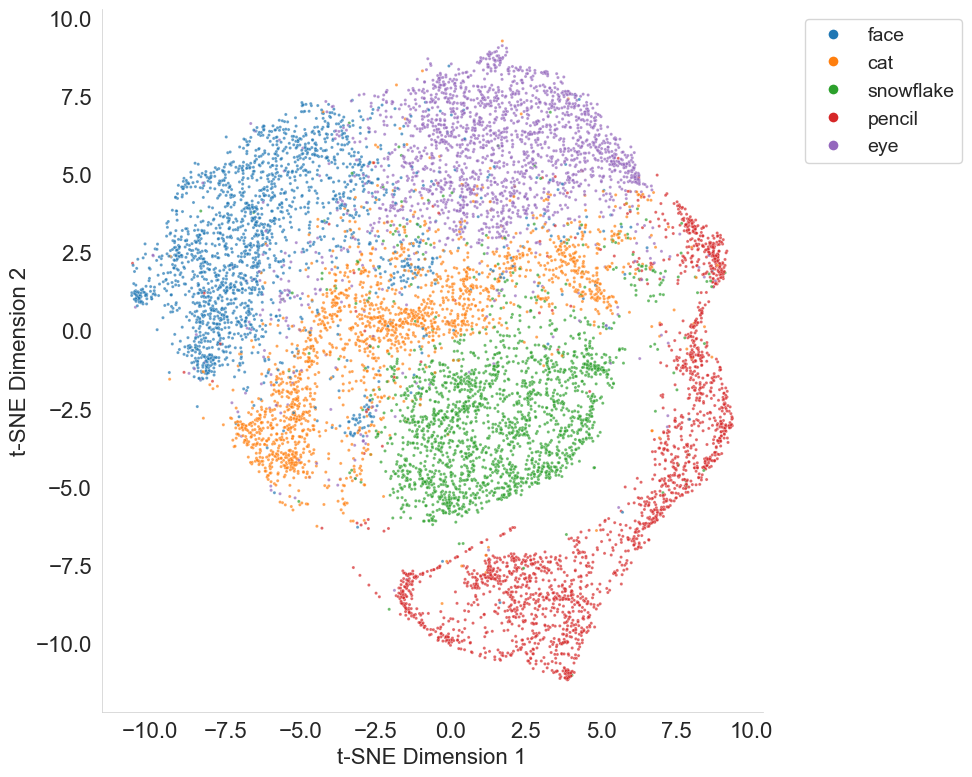

In [19]:
# Determine number of unique classes
category_names = get_category_names_from_dataloader(test_loader)
unique_classes = np.unique(plot_labels)
num_classes = len(unique_classes)

# Set up figure
plt.figure(figsize=(10, 8))

# Set seaborn style for minimalist plot
sns.set_style("whitegrid", {'axes.grid': False})
# Increase default font size
plt.rcParams.update({'font.size': 14})

# Create a title for the plot
title = f""

# Create scatter plot with consistent colors
ax = sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], 
                     hue=plot_labels, palette="tab10",
                     s=5, alpha=0.7, legend=False)

# Minimal axes - remove top and right spines
sns.despine(top=True, right=True)
ax.spines['left'].set_lw(0.5)
ax.spines['bottom'].set_lw(0.5)
ax.tick_params(width=0.5)

# Create legend with category names (with larger font)
if category_names and num_classes <= 20:
    handles = []
    # Get the colormap being used
    cmap = plt.cm.tab10
    
    for i, class_idx in enumerate(unique_classes):
        if class_idx in category_names:
            color = cmap(i % 10)  # Use consistent color mapping
            handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=color, markersize=8, 
                                     label=category_names[class_idx]))
    
    if handles:
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)

# Increase font size for axis labels
plt.xlabel('t-SNE Dimension 1', fontsize=16)
plt.ylabel('t-SNE Dimension 2', fontsize=16)
plt.title(title, fontsize=18)
plt.tight_layout()

# Save the visualization
save_path = os.path.join(model_dir, 'latent_space_visualization.svg')
plt.savefig(save_path, bbox_inches='tight', dpi=150)
print(f"Latent space visualization saved to {save_path}")
plt.show()


In [20]:
set(selected_experts)

{1, 3, 4, 5, 6}

In [21]:
expert_mapping = {1:1, 3:2, 4:3, 5:4, 6:5}
selected_experts_relabeled = [expert_mapping.get(expert, expert) for expert in selected_experts]
color_mapping = {1:1, 2:5, 3:2, 4:3, 5:4}
selected_experts_colored = [color_mapping.get(expert, expert) for expert in selected_experts_relabeled]

Expert activation visualization saved to results/moe_ld32_ne10_1.0_dataset_percentage_4\expert_activation_visualization.svg


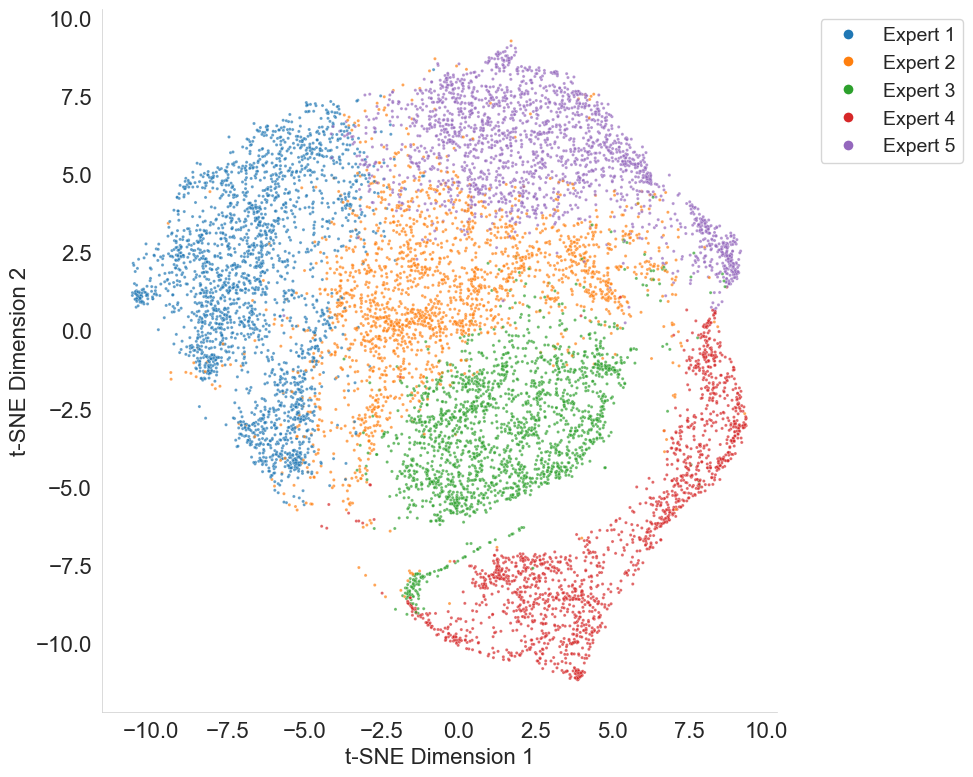

In [22]:
# Create a scatter plot, coloring by selected expert index
plt.figure(figsize=(10, 8))

# Set seaborn style for minimalist plot
sns.set_style("whitegrid", {'axes.grid': False})
#
# Create a title for the plot
title = f""
plt.rcParams.update({'font.size': 14})

# Create scatter plot with consistent colors
ax = sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], 
                     hue=[e for e in selected_experts_colored],
                     palette="tab10", s=5, alpha=0.7, legend=False)

# Minimal axes - remove top and right spines
sns.despine(top=True, right=True)
ax.spines['left'].set_lw(0.5)
ax.spines['bottom'].set_lw(0.5)
ax.tick_params(width=0.5)

# Create legend with expert names
unique_experts = sorted(set(selected_experts_colored))
handles = []
cmap = plt.cm.tab10

for i, expert_idx in enumerate(unique_experts):
    color = cmap(i % 10)  # Use consistent color mapping
    handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=color, markersize=8, 
                             label=f"Expert {expert_idx}"))

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)

plt.xlabel('t-SNE Dimension 1', fontsize=16)
plt.ylabel('t-SNE Dimension 2', fontsize=16)
plt.title(title)
plt.tight_layout()

# Save the expert activation visualization
save_path = os.path.join(model_dir, 'expert_activation_visualization.svg')
plt.savefig(save_path, bbox_inches='tight', dpi=150)
print(f"Expert activation visualization saved to {save_path}")
plt.show()


Active experts: 5/10
Inactive experts (< 10 samples): [0, 2, 7, 8, 9]


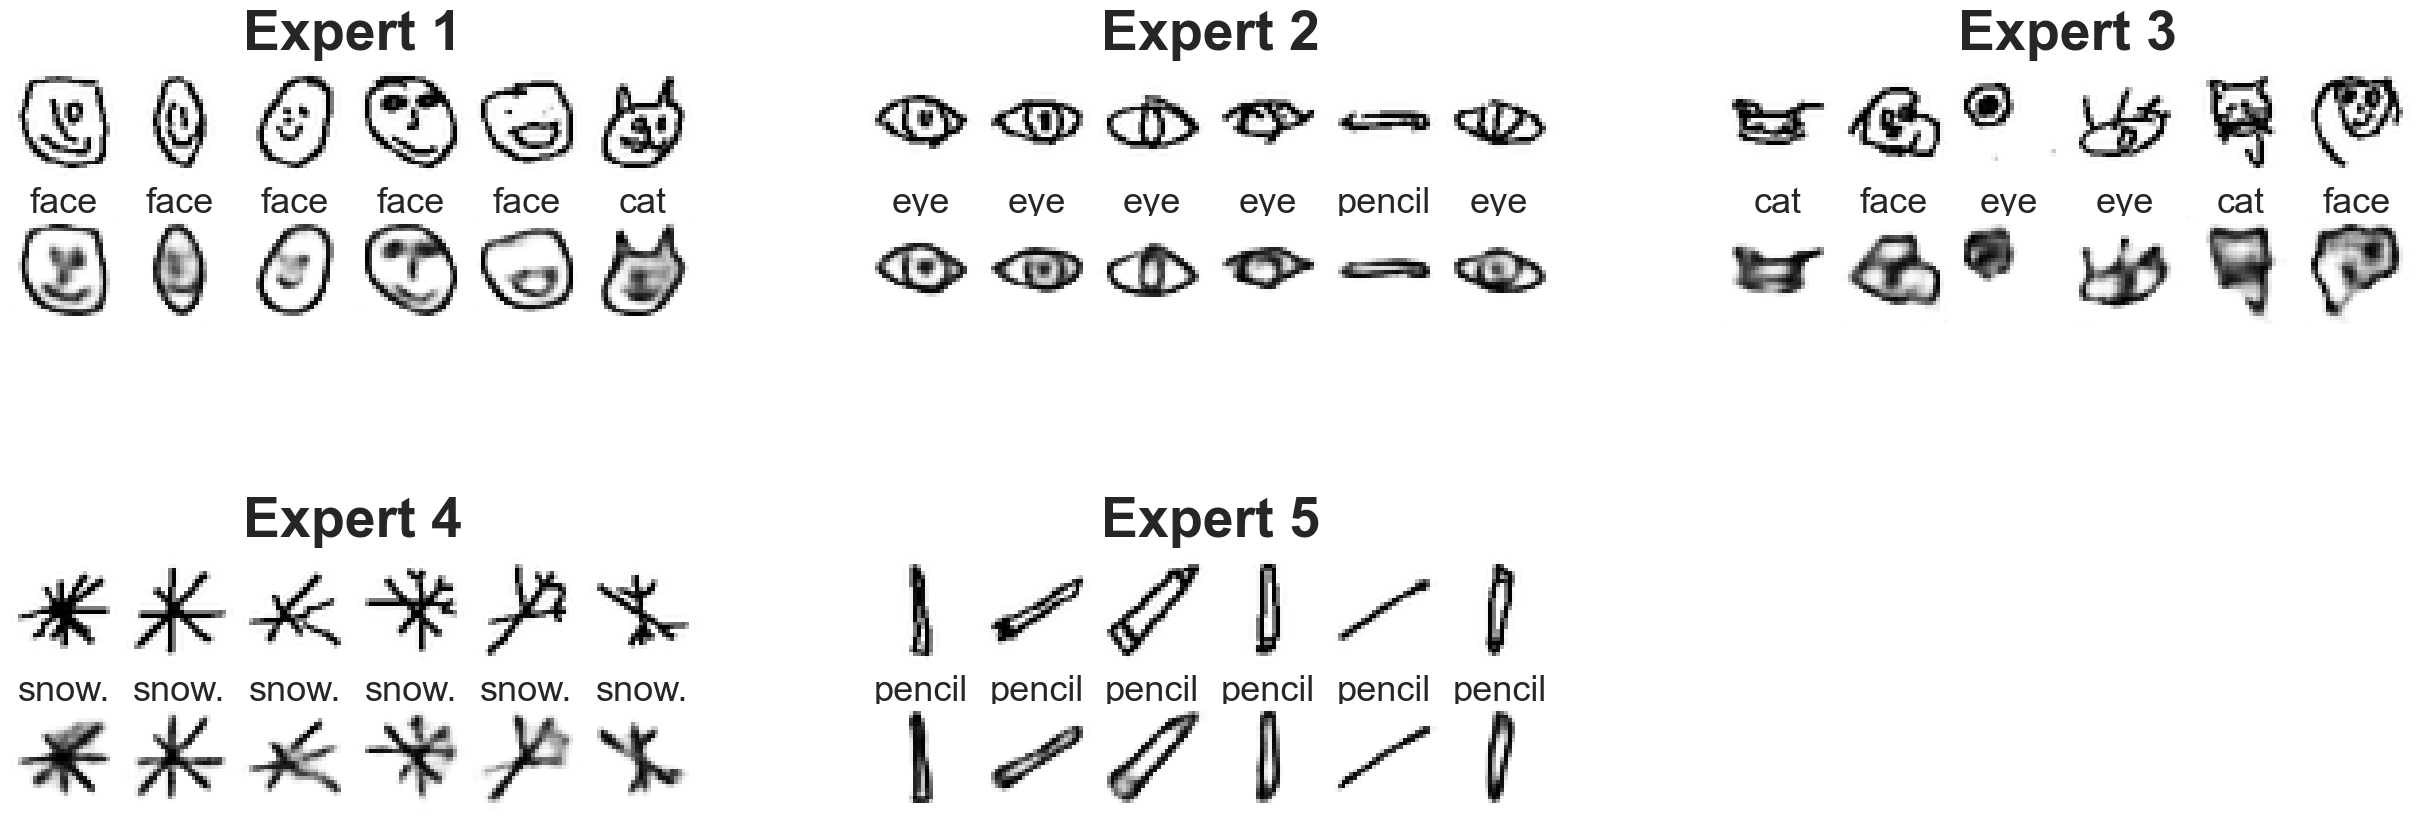

Expert specialization visualization saved to results/moe_ld32_ne10_1.0_dataset_percentage_4\expert_specialization_visualization.png


In [23]:
model.eval()
max_samples_per_expert = 6  # Number of samples to show per expert
min_samples_threshold = 10  # Minimum samples to consider an expert active

# Collect data for each expert
expert_data = {i: {'images': [], 'labels': [], 'confidences': [], 'reconstructions': []} 
                for i in range(num_experts)}
expert_counts = np.zeros(num_experts)

# Process data and collect samples for each expert
print("Collecting expert specialization data...")
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.cpu().numpy()
        
        # Get model outputs
        reconstructed_x, _, _, logits, _ = model(data)
        
        # Get expert selection probabilities and most likely expert for each sample
        expert_probs = torch.softmax(logits, dim=-1)
        selected_experts = torch.argmax(logits, dim=-1).cpu().numpy()
        max_confidences = torch.max(expert_probs, dim=-1)[0].cpu().numpy()
        
        # Store samples for each expert
        for i in range(data.shape[0]):
            expert_idx = selected_experts[i]
            expert_counts[expert_idx] += 1
            
            # Only keep samples if we haven't collected enough yet
            if len(expert_data[expert_idx]['images']) < max_samples_per_expert * 3:  # Collect more to select best
                expert_data[expert_idx]['images'].append(data[i].cpu())
                expert_data[expert_idx]['labels'].append(labels[i])
                expert_data[expert_idx]['confidences'].append(max_confidences[i])
                expert_data[expert_idx]['reconstructions'].append(reconstructed_x[i].cpu())
        
        # Break early if we have enough samples for all active experts
        if batch_idx > 50:  # Process reasonable amount of data
            break

# Select best samples for each expert based on confidence
for expert_idx in range(num_experts):
    if len(expert_data[expert_idx]['images']) > max_samples_per_expert:
        # Sort by confidence and take the most confident samples
        sorted_indices = np.argsort(expert_data[expert_idx]['confidences'])[::-1]
        top_indices = sorted_indices[:max_samples_per_expert]
        
        expert_data[expert_idx]['images'] = [expert_data[expert_idx]['images'][i] for i in top_indices]
        expert_data[expert_idx]['labels'] = [expert_data[expert_idx]['labels'][i] for i in top_indices]
        expert_data[expert_idx]['confidences'] = [expert_data[expert_idx]['confidences'][i] for i in top_indices]
        expert_data[expert_idx]['reconstructions'] = [expert_data[expert_idx]['reconstructions'][i] for i in top_indices]

# Get category names if available
category_names = get_category_names_from_dataloader(test_loader)

# Identify active experts (those with enough samples)
active_experts = [i for i in range(num_experts) if expert_counts[i] >= min_samples_threshold]
inactive_experts = [i for i in range(num_experts) if expert_counts[i] < min_samples_threshold]

print(f"Active experts: {len(active_experts)}/{num_experts}")
if inactive_experts:
    print(f"Inactive experts (< {min_samples_threshold} samples): {inactive_experts}")

# Calculate grid layout for active experts
if len(active_experts) == 0:
    print("No active experts found!")

# Determine optimal grid layout
if len(active_experts) <= 2:
    n_cols = len(active_experts)
    n_rows = 1
elif len(active_experts) <= 6:
    n_cols = min(3, len(active_experts))
    n_rows = (len(active_experts) + n_cols - 1) // n_cols
elif len(active_experts) <= 12:
    n_cols = 4
    n_rows = (len(active_experts) + n_cols - 1) // n_cols
else:
    n_cols = 5
    n_rows = (len(active_experts) + n_cols - 1) // n_cols
    # For very large numbers of experts, limit the display
    if n_rows > 10:
        print(f"Too many active experts ({len(active_experts)}), showing top 50 by usage")
        # Sort by usage count and take top experts
        expert_usage = [(i, expert_counts[i]) for i in active_experts]
        expert_usage.sort(key=lambda x: x[1], reverse=True)
        active_experts = [x[0] for x in expert_usage[:50]]
        n_rows = 10

# Calculate figure size - now with 6 samples per expert
samples_per_row = min(max_samples_per_expert, 6)  # Show up to 6 samples per expert
fig_width = n_cols * (samples_per_row * 2.0 + 2)  # Adjust width for 6 samples + title space
fig_height = n_rows * 4.5  # Increase height per expert row for better spacing
fig_width = min(fig_width, 25)  # Maximum width
fig_height = min(fig_height, 30)  # Maximum height

# Set default font sizes larger
plt.rcParams.update({
    'font.size': 18,          # Default font size
    'axes.titlesize': 20,     # Axes title font size
    'axes.labelsize': 18,     # Axes label font size
    'xtick.labelsize': 16,    # X-axis tick label size
    'ytick.labelsize': 16,    # Y-axis tick label size
    'legend.fontsize': 18,    # Legend font size
    'figure.titlesize': 24    # Figure title size
})

# Create the plot with better spacing
fig = plt.figure(figsize=(fig_width, fig_height))

# Create main grid with more spacing for titles
main_gs = fig.add_gridspec(n_rows, n_cols, hspace=0.6, wspace=0.25, 
                            top=0.93, bottom=0.05, left=0.02, right=0.98)

for plot_idx, expert_idx in enumerate(active_experts[:n_rows * n_cols]):
    expert_images = expert_data[expert_idx]['images']
    expert_labels = expert_data[expert_idx]['labels']
    expert_recons = expert_data[expert_idx]['reconstructions']
    
    if not expert_images:
        continue
        
    # Determine number of samples to show for this expert
    num_samples_to_show = min(len(expert_images), samples_per_row)
    
    # Get position in grid
    expert_row = plot_idx // n_cols
    expert_col = plot_idx % n_cols
    
    # Create nested grid for this expert's samples (reserve space for title)
    expert_outer_gs = main_gs[expert_row, expert_col].subgridspec(3, 1, 
                                                                  height_ratios=[0.15, 1, 1],
                                                                  hspace=0.1)
    
    # Title area
    title_ax = fig.add_subplot(expert_outer_gs[0, 0])
    title_ax.axis('off')
    expert_title = f"Expert {plot_idx + 1}"
    title_ax.text(0.5, 0.7, expert_title, ha='center', va='center', 
                  fontsize=40, weight='bold', transform=title_ax.transAxes)

    
    # Images grid
    images_gs = expert_outer_gs[1:, 0].subgridspec(2, num_samples_to_show, 
                                                  hspace=0.15, wspace=0.08)
    
    # Show original and reconstructed images
    for sample_idx in range(num_samples_to_show):
        # Original image
        ax_orig = fig.add_subplot(images_gs[0, sample_idx])
        img = expert_images[sample_idx].squeeze().numpy()
        ax_orig.imshow(img, cmap='gray')
        ax_orig.axis('off')
        
        # Add class label for all original images
        label = expert_labels[sample_idx]
        label_text = category_names.get(label, str(label)) if category_names else str(label)
        if label_text == "snowflake":
            label_text = "snow."

        ax_orig.text(0.5, -0.1, label_text, ha='center', va='top', 
                    fontsize=26, transform=ax_orig.transAxes)
        
        # Reconstructed image
        ax_recon = fig.add_subplot(images_gs[1, sample_idx])
        recon_img = expert_recons[sample_idx].squeeze().numpy()
        ax_recon.imshow(recon_img, cmap='gray')
        ax_recon.axis('off')

save_path = os.path.join(model_dir, 'expert_specialization_visualization.png')
plt.savefig(save_path, bbox_inches='tight', dpi=150)
plt.show()

print(f"Expert specialization visualization saved to {save_path}")
plt.close()


## Performance vs number of experts and dataset size

In [36]:
import pickle

with open("results/test_losses_data.pkl", "rb") as f:
    test_losses_percentage = pickle.load(f)

with open('results/supervised_losses.pkl', 'rb') as f:
    supervised_losses = pickle.load(f)

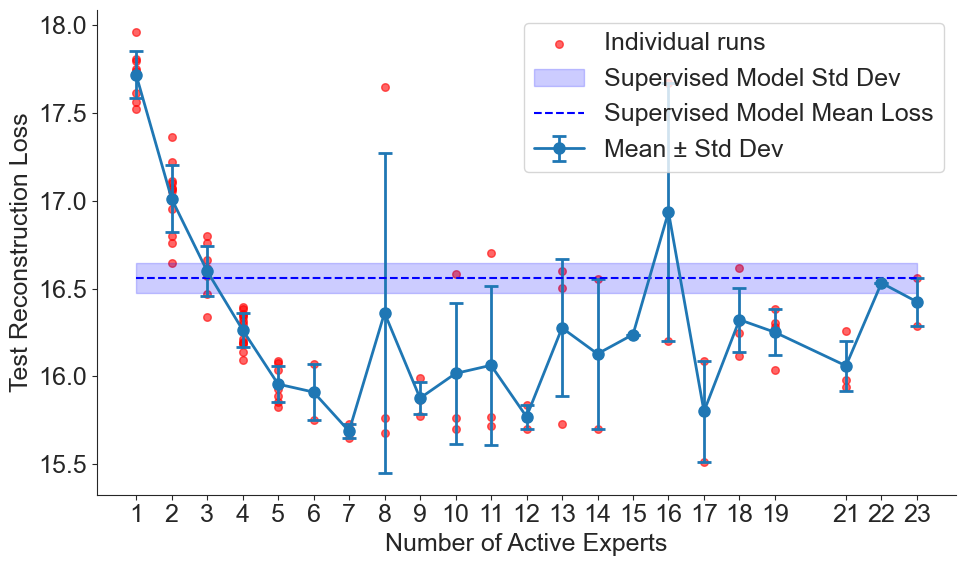

In [37]:
# Calculate mean and std for each number of experts
test_losses_by_active_experts = test_losses_percentage[1.0]
experts_stats = {}
for num_experts, losses_list in test_losses_by_active_experts.items():
    # Extract the last loss value from each experiment
    final_losses = [losses[-1] for losses in losses_list]
    
    experts_stats[num_experts] = {
        'mean': np.mean(final_losses),
        'std': np.std(final_losses),
        'count': len(final_losses),
        'values': final_losses
    }

# Prepare data for plotting
expert_numbers = sorted(experts_stats.keys())
means = [experts_stats[num]['mean'] for num in expert_numbers]
stds = [experts_stats[num]['std'] for num in expert_numbers]


## Set the Seaborn style
sns.set_style("ticks")

# Create the figure
plt.figure(figsize=(10, 6))

# Use matplotlib's errorbar for the main plot
plt.errorbar(expert_numbers, means, yerr=stds, 
             marker='o', capsize=5, capthick=2, 
             linewidth=2, markersize=8, 
             color='#1f77b4', label='Mean ± Std Dev')

# Add individual data points for transparency
for i, num_experts in enumerate(expert_numbers):
    values = experts_stats[num_experts]['values']
    x_positions = [num_experts] * len(values)
    plt.scatter(x_positions, values, alpha=0.6, s=30, color='red', 
                label='Individual runs' if i == 0 else "")

# Set axis labels
plt.xlabel('Number of Active Experts')
plt.ylabel('Test Reconstruction Loss')

# Add supervised model reference line and band
plt.fill_between(expert_numbers, 
                 np.mean(supervised_losses) - np.std(supervised_losses),
                 np.mean(supervised_losses) + np.std(supervised_losses),
                 alpha=0.2, color='blue', label='Supervised Model Std Dev')
plt.hlines(np.mean(supervised_losses), xmin=min(expert_numbers), xmax=max(expert_numbers), 
           color='blue', linestyle='--', label='Supervised Model Mean Loss')

# Set x-ticks to ensure they match the exact expert numbers
plt.xticks(expert_numbers)

# Remove top and right spines
sns.despine()

# Add legend and adjust layout
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
def plot_test_losses_by_percentage(test_losses_percentage):
    # Set the Seaborn style
    sns.set_style("ticks")
    
    # Create the plot
    plt.figure(figsize=(10, 10))
    
    # Sort percentages for consistent color shading
    sorted_percentages = sorted(test_losses_percentage.keys())
    # Create a blue color map from light to dark
    blue_shades = plt.cm.Blues(np.linspace(0.3, 0.9, len(sorted_percentages)))
    
    for i, percentage in enumerate(sorted_percentages):
        test_losses_by_active_experts = test_losses_percentage[percentage]
        # Calculate mean and std for each number of experts
    
        experts_stats = {}
        for num_experts, losses_list in test_losses_by_active_experts.items():
            # Extract the last loss value from each experiment
            final_losses = [losses[-1] for losses in losses_list]
            
            experts_stats[num_experts] = {
                'mean': np.mean(final_losses),
                'std': np.std(final_losses),
                'count': len(final_losses),
                'values': final_losses
            }

        # Prepare data for plotting
        expert_numbers = sorted(experts_stats.keys())
        means = [experts_stats[num]['mean'] for num in expert_numbers]
        stds = [experts_stats[num]['std'] for num in expert_numbers]

        plt.errorbar(expert_numbers, means, yerr=stds, 
                    marker='o', capsize=5, capthick=2, 
                    linewidth=2, markersize=8, 
                    color=blue_shades[i],
                    label='Dataset percentage: {:.0%}'.format(percentage))

        # add marker for the lowest point - now using a red cross
        min_expert = min(expert_numbers, key=lambda x: experts_stats[x]['mean'])
        min_loss = experts_stats[min_expert]['mean']
        plt.plot(min_expert, min_loss, 'rx', markersize=8, markeredgewidth=2, zorder=5)

        print(f"\nSummary Statistics for {percentage:.0%} dataset:")
        print("-" * 60)
        for num_experts in expert_numbers:
            stats = experts_stats[num_experts]
            print(f"Active Experts: {num_experts:2d} | "
            f"Mean: {stats['mean']:8.4f} | "
            f"Std: {stats['std']:7.4f} | "
            f"Count: {stats['count']:2d}")

    # Set axis labels
    plt.xlabel('Number of Active Experts')
    plt.ylabel('Test Reconstruction Loss')
    
    # Set x-ticks
    plt.xticks(range(min(expert_numbers), max(expert_numbers)+1))
    
    # Remove top and right spines
    sns.despine()

    plt.legend()
    plt.tight_layout()
    plt.show()


Summary Statistics for 5% dataset:
------------------------------------------------------------
Active Experts:  1 | Mean:  23.9650 | Std:  0.4057 | Count:  7
Active Experts:  2 | Mean:  23.1454 | Std:  1.2724 | Count: 11
Active Experts:  3 | Mean:  22.0849 | Std:  0.1804 | Count: 11
Active Experts:  4 | Mean:  22.2031 | Std:  0.8864 | Count: 14
Active Experts:  5 | Mean:  22.5252 | Std:  0.9494 | Count:  5
Active Experts:  6 | Mean:  23.2691 | Std:  1.1492 | Count:  3
Active Experts:  7 | Mean:  23.5783 | Std:  0.0000 | Count:  1
Active Experts:  8 | Mean:  23.6025 | Std:  1.8234 | Count:  4
Active Experts:  9 | Mean:  22.4143 | Std:  0.0987 | Count:  2
Active Experts: 10 | Mean:  23.4015 | Std:  0.0235 | Count:  2
Active Experts: 12 | Mean:  24.4188 | Std:  0.8215 | Count:  4
Active Experts: 13 | Mean:  25.6105 | Std:  1.1021 | Count:  2
Active Experts: 14 | Mean:  25.8442 | Std:  0.4115 | Count:  2
Active Experts: 15 | Mean:  25.0704 | Std:  0.9756 | Count:  3
Active Experts: 16 | 

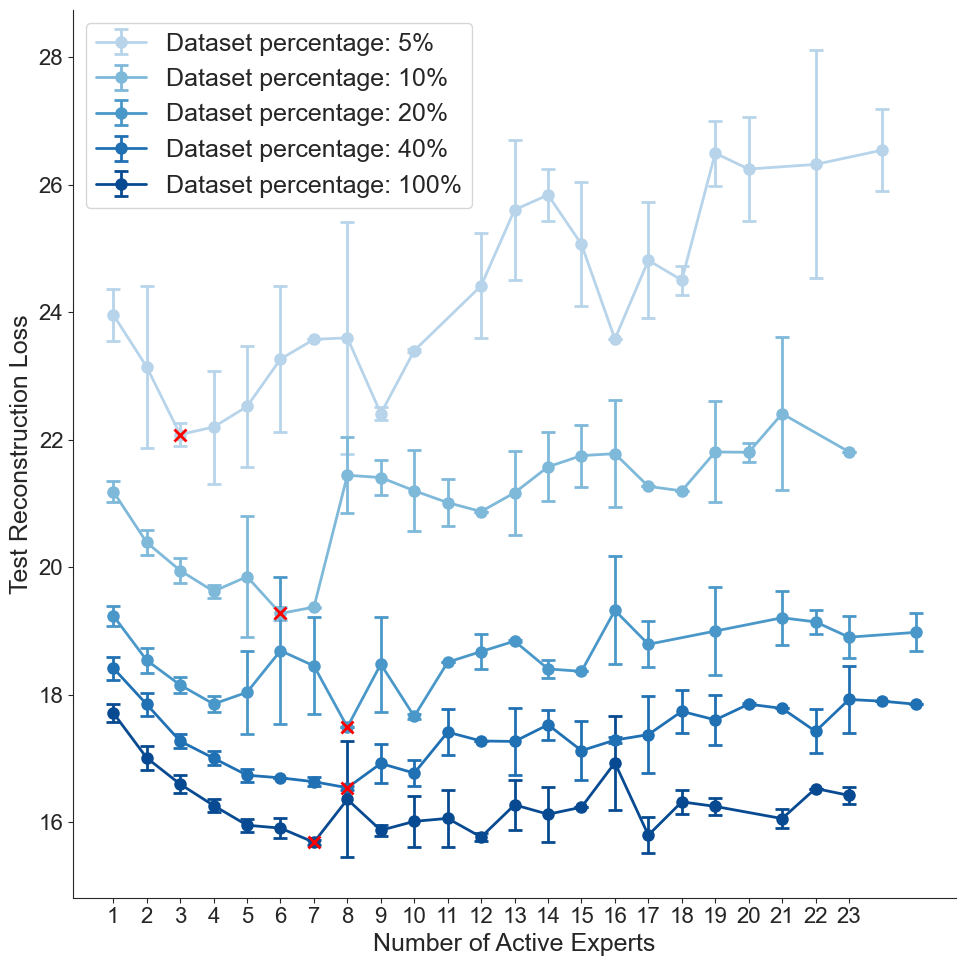

In [28]:
plot_test_losses_by_percentage(test_losses_percentage)


Summary Statistics for 5% dataset:
------------------------------------------------------------
Active Experts:  1 | Samples/Expert: 17500 | Mean:  23.9650 | Std:  0.4057 | Count:  7
Active Experts:  2 | Samples/Expert: 8750 | Mean:  23.1454 | Std:  1.2724 | Count: 11
Active Experts:  3 | Samples/Expert: 5833 | Mean:  22.0849 | Std:  0.1804 | Count: 11
Active Experts:  4 | Samples/Expert: 4375 | Mean:  22.2031 | Std:  0.8864 | Count: 14
Active Experts:  5 | Samples/Expert: 3500 | Mean:  22.5252 | Std:  0.9494 | Count:  5
Active Experts:  6 | Samples/Expert: 2917 | Mean:  23.2691 | Std:  1.1492 | Count:  3
Active Experts:  7 | Samples/Expert: 2500 | Mean:  23.5783 | Std:  0.0000 | Count:  1
Active Experts:  8 | Samples/Expert: 2188 | Mean:  23.6025 | Std:  1.8234 | Count:  4
Active Experts:  9 | Samples/Expert: 1944 | Mean:  22.4143 | Std:  0.0987 | Count:  2
Active Experts: 10 | Samples/Expert: 1750 | Mean:  23.4015 | Std:  0.0235 | Count:  2
Active Experts: 12 | Samples/Expert: 1458 

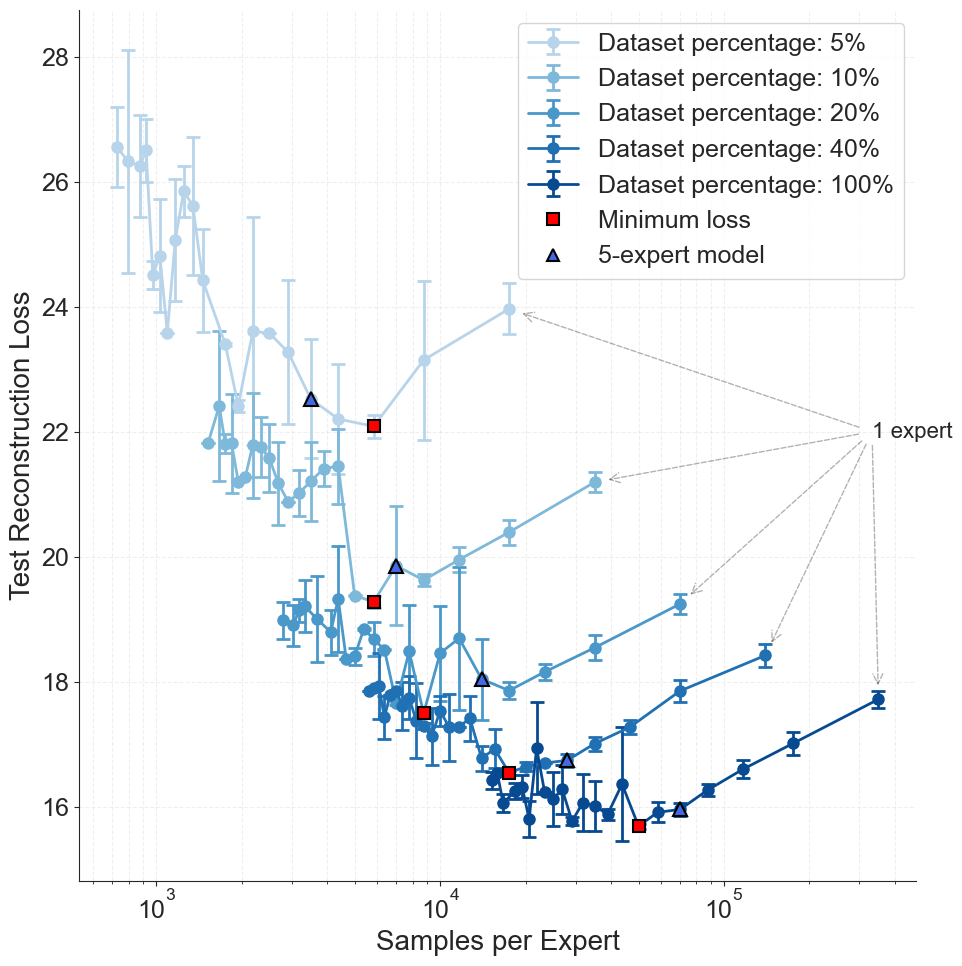

In [29]:
sorted_percentages = sorted(test_losses_percentage.keys())
blue_shades = plt.cm.Blues(np.linspace(0.3, 0.9, len(sorted_percentages)))
DATASET_SIZE = 350000


# Set the Seaborn style
sns.set_style("ticks")

# Set font sizes globally
plt.rcParams.update({
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
})

fig, ax1 = plt.subplots(figsize=(10, 10))

# Sort percentages for consistent color shading
# (blue_shades and sorted_percentages already defined)

five_expert_markers = []

for i, percentage in enumerate(sorted_percentages):
    test_losses_by_active_experts = test_losses_percentage[percentage]
    experts_stats = {}
    for num_experts, losses_list in test_losses_by_active_experts.items():
        final_losses = [losses[-1] for losses in losses_list]
        experts_stats[num_experts] = {
            'mean': np.mean(final_losses),
            'std': np.std(final_losses),
            'count': len(final_losses),
            'values': final_losses,
            'samples_per_expert': (DATASET_SIZE * percentage) / num_experts
        }

    expert_numbers = sorted(experts_stats.keys())
    means = [experts_stats[num]['mean'] for num in expert_numbers]
    stds = [experts_stats[num]['std'] for num in expert_numbers]
    samples_per_expert = [experts_stats[num]['samples_per_expert'] for num in expert_numbers]

    line = ax1.errorbar(samples_per_expert, means, yerr=stds, 
                marker='o', capsize=5, capthick=2, 
                linewidth=2, markersize=8, 
                color=blue_shades[i],
                label='Dataset percentage: {:.0%}'.format(percentage))

    min_expert = min(expert_numbers, key=lambda x: experts_stats[x]['mean'])
    min_loss = experts_stats[min_expert]['mean']
    min_samples = experts_stats[min_expert]['samples_per_expert']
    ax1.plot(min_samples, min_loss, 's', color='red', markersize=8, 
             markeredgecolor='black', markeredgewidth=1.5, zorder=5)

    if 5 in experts_stats:
        marker = {
            'samples': experts_stats[5]['samples_per_expert'],
            'loss': experts_stats[5]['mean'],
            'color': 'royalblue'
        }
        five_expert_markers.append(marker)
        ax1.plot(marker['samples'], marker['loss'], '^', color=marker['color'], 
                markersize=10, markeredgecolor='black', markeredgewidth=1.5, zorder=4)

    print(f"\nSummary Statistics for {percentage:.0%} dataset:")
    print("-" * 60)
    for num_experts in expert_numbers:
        stats = experts_stats[num_experts]
        samples = stats['samples_per_expert']
        print(f"Active Experts: {num_experts:2d} | "
        f"Samples/Expert: {samples:.0f} | "
        f"Mean: {stats['mean']:8.4f} | "
        f"Std: {stats['std']:7.4f} | "
        f"Count: {stats['count']:2d}")

# Primary x-axis
ax1.set_xlabel('Samples per Expert', fontsize=20)
ax1.set_ylabel('Test Reconstruction Loss', fontsize=20)
ax1.set_xscale('log')
ax1.grid(True, which="both", ls="--", alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', 
                         markersize=8, markeredgecolor='black', markeredgewidth=1.5, label='Minimum loss'))
handles.append(plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='royalblue', 
                         markersize=8, markeredgecolor='black', markeredgewidth=1.5, label='5-expert model'))

# --- Annotation for all 1-expert model points ---
# Collect all points corresponding to 1 expert
one_expert_points = []
for percentage in sorted_percentages:
    stats = test_losses_percentage[percentage]
    if 1 in stats:
        one_expert_points.append({
            'samples': (DATASET_SIZE * percentage) / 1,
            'loss': np.mean([l[-1] for l in stats[1]])
        })

if one_expert_points:
    # Position the text to the right of the rightmost point
    last_point = one_expert_points[-1]
    text_x = last_point['samples'] * 0.95
    text_y = 22
    
    ax1.text(text_x, text_y, "1 expert", fontsize=16, ha="left", va="center", zorder=7)

    # Draw a dashed arrow from the text to each 1-expert point
    for point in one_expert_points:
        ax1.annotate("",
            xy=(point['samples'], point['loss']),
            xytext=(text_x, text_y),
            arrowprops=dict(arrowstyle="->", linestyle="--", lw=1.0, color="black", alpha=0.3, shrinkA=10, shrinkB=10),
            zorder=6
        )



sns.despine(ax=ax1)

plt.legend(handles=handles, fontsize=18, loc='best')
plt.tight_layout()
plt.savefig('snapshots/test_recon_losses_by_samples_per_expert.png', dpi=300)
plt.savefig('snapshots/test_recon_losses_by_samples_per_expert.svg', dpi=300)
plt.show()


In [30]:
# Collect all data into lists
DATASET_SIZE = 350000
all_x = []   # number of experts
all_y = []   # samples per expert
all_loss = []  # mean loss

sorted_percentages = sorted(test_losses_percentage.keys())

for percentage in sorted_percentages:
    test_losses_by_active_experts = test_losses_percentage[percentage]

    for num_experts, losses_list in test_losses_by_active_experts.items():
        final_losses = [losses[-1] for losses in losses_list]
        mean_loss = np.mean(final_losses)
        samples_per_expert = (DATASET_SIZE * percentage) / num_experts

        all_x.append(num_experts)
        all_y.append(samples_per_expert)
        all_loss.append(mean_loss)

# Convert to arrays
all_x = np.array(all_x)
all_y = np.array(all_y)
all_loss = np.array(all_loss)


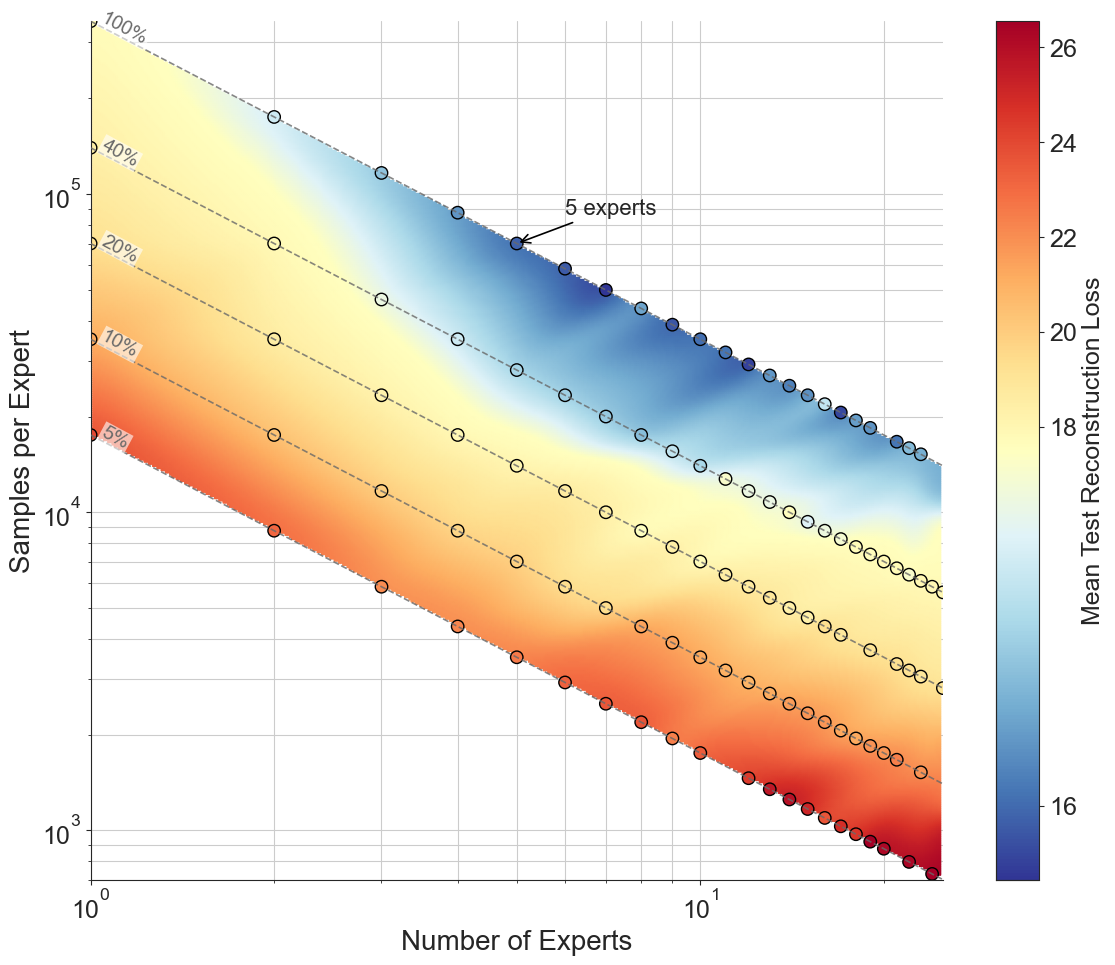

In [31]:
from matplotlib import colors
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from matplotlib.path import Path

# Increase font sizes
plt.rcParams.update({
    'font.size': 18,          # Default font size
    'axes.titlesize': 22,     # Axes title font size
    'axes.labelsize': 18,     # Axes label font size
    'xtick.labelsize': 18,    # X-axis tick label size
    'ytick.labelsize': 18,    # Y-axis tick label size
    'legend.fontsize': 18,    # Legend font size
})

# Data (already computed above)
x = np.asarray(all_x)
y = np.asarray(all_y)
z = np.asarray(all_loss)

# Work in log-space to respect geometry on log-log plot
u = np.log10(x)   # log10(#experts)
v = np.log10(y)   # log10(samples/expert)

# Parallelogram in (u,v): bounds set by min/max percentage and min/max x
Kmin = DATASET_SIZE * min(sorted_percentages)
Kmax = DATASET_SIZE * max(sorted_percentages)
umin, umax = u.min(), u.max()

# Corners of the parallelogram in (u,v)
corners = np.array([
    [umin, np.log10(Kmax) - umin],  # upper-left
    [umax, np.log10(Kmax) - umax],  # upper-right
    [umax, np.log10(Kmin) - umax],  # lower-right
    [umin, np.log10(Kmin) - umin],  # lower-left
])
poly = Path(corners)

# Create a regular rectangular grid that fully contains the parallelogram
vmin = (np.log10(Kmin) - umax)
vmax = (np.log10(Kmax) - umin)
U, V = np.meshgrid(
    np.linspace(umin, umax, 400),
    np.linspace(vmin, vmax, 400),
)

# Interpolate z on the (U,V) grid
Z_lin = griddata((u, v), z, (U, V), method="linear")
# Fill remaining NaNs (outside convex hull of samples but inside polygon) with nearest
Z_near = griddata((u, v), z, (U, V), method="nearest")
Z = np.where(np.isnan(Z_lin), Z_near, Z_lin)

# Mask outside the parallelogram
inside = poly.contains_points(np.c_[U.ravel(), V.ravel()]).reshape(U.shape)

# --- Smooth Z inside the polygon (Gaussian, mask-aware) ---
sigma = 5.0  # tune 0.5–2.0 for less/more smoothing
Z_filled = np.where(inside, Z, 0.0).astype(float)
W = inside.astype(float)

Z_blur = gaussian_filter(Z_filled, sigma=sigma, mode="nearest")
W_blur = gaussian_filter(W, sigma=sigma, mode="nearest")
Z_smooth = np.divide(Z_blur, W_blur, out=np.zeros_like(Z_blur), where=W_blur > 1e-8)

# Use smoothed data with mask applied
Z = np.ma.array(Z_smooth, mask=~inside)
# ----------------------------------------------------------

# Plot in original (x,y) with log axes
X = 10**U
Y = 10**V

# ---- Color scale with high contrast around 16–17 (Option A) ----
cmin = float(np.nanmin(z))
cmax = float(np.nanmax(z))
vcenter = 17.5  # adjust to emphasize 16–17
cmap = plt.get_cmap("RdYlBu_r")  # e.g., "coolwarm", "Spectral_r"
norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=vcenter, vmax=cmax)
# ----------------------------------------------------------------

plt.figure(figsize=(12, 10))  # Slightly larger figure

# Create the contour plot
c = plt.pcolormesh(X, Y, Z, cmap=cmap, norm=norm, shading="gouraud")  # smoother shading

# Add data points
plt.scatter(x, y, c=z, cmap=cmap, norm=norm, edgecolor="k", s=80)  # Larger points

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Experts", fontsize=20)
plt.ylabel("Samples per Expert", fontsize=20)


cbar = plt.colorbar(c)
cbar.set_label("Mean Test Reconstruction Loss", fontsize=18)
cbar.ax.tick_params(labelsize=18)

plt.grid(True, which="both", ls="--", alpha=0.3)
sns.despine()

# ...existing code...
plt.grid(True, which="both", ls="-", alpha=1.0)
sns.despine()

# --- Constant dataset-percentage lines and labels ---
ax = plt.gca()
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# Use existing percentages if available; otherwise default set
percentages_to_show = sorted_percentages if 'sorted_percentages' in globals() else [0.05, 0.1, 0.2, 0.4, 1.0]

# Draw lines y = (DATASET_SIZE * p) / x across the current x-range
x_line = np.logspace(np.log10(xmin), np.log10(xmax), 400)

for p in percentages_to_show:
    K = DATASET_SIZE * p
    y_line = K / x_line

    # Line
    ax.plot(x_line, y_line, ls="--", lw=1.2, color="dimgray", alpha=0.8, zorder=3)

    # Label near the left edge, kept inside axes bounds
    x_lab = xmin * 1.03
    y_lab = K / x_lab
    if y_lab < ymin:
        x_lab = K / ymin
        y_lab = ymin * 1.02
    elif y_lab > ymax:
        x_lab = K / ymax
        y_lab = ymax / 1.02

    # Rotate text to follow the line in display coordinates
    p1 = ax.transData.transform([x_line[0], y_line[0]])
    p2 = ax.transData.transform([x_line[10], y_line[10]])
    angle = np.degrees(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))

    ax.text(
        x_lab, y_lab, f"{int(round(p*100))}%",
        color="dimgray", fontsize=14, rotation=angle, rotation_mode="anchor",
        ha="left", va="bottom",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=1.0),
        zorder=4,
    )

ax = plt.gca()
x_target = 5
mask5 = np.isclose(x, x_target)
if np.any(mask5):
    y0 = np.max(y[mask5])
    # place text slightly up-right (safe inside axes on log scale)
    xmax, ymax = ax.get_xlim()[1], ax.get_ylim()[1]
    x_text = min(x_target * 1.2, xmax / 1.05)
    y_text = min(y0 * 1.2, ymax / 1.05)
    ax.annotate(
        "5 experts",
        xy=(x_target, y0),
        xytext=(x_text, y_text),
        fontsize=16,
        ha="left", va="bottom",
        arrowprops=dict(arrowstyle="->", lw=1.2, color="black"),
        zorder=6,
    )
    
plt.tight_layout()
plt.savefig("snapshots/interpolated_test_recon_loss_loglog.png", dpi=300)
plt.savefig("snapshots/interpolated_test_recon_loss_loglog.svg", dpi=300)
plt.show()

## Other datasets

### MNIST Digits

In [38]:
with open('results/losses_experts_digits.pkl', 'rb') as f:
    losses_experts = pickle.load(f)

n_experts = list(losses_experts.keys())

In [40]:
# Calculate the mean and standard deviation of those entries
losses_experts_stats = {k: {'mean': np.mean(v), 'std': np.std(v)} for k, v in losses_experts.items()}

C:\Users\DELL\AppData\Local\Temp\ipykernel_4944\3379556591.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=n_experts, y=means, marker='o', label='Mean', err_style="bars", ci=None)


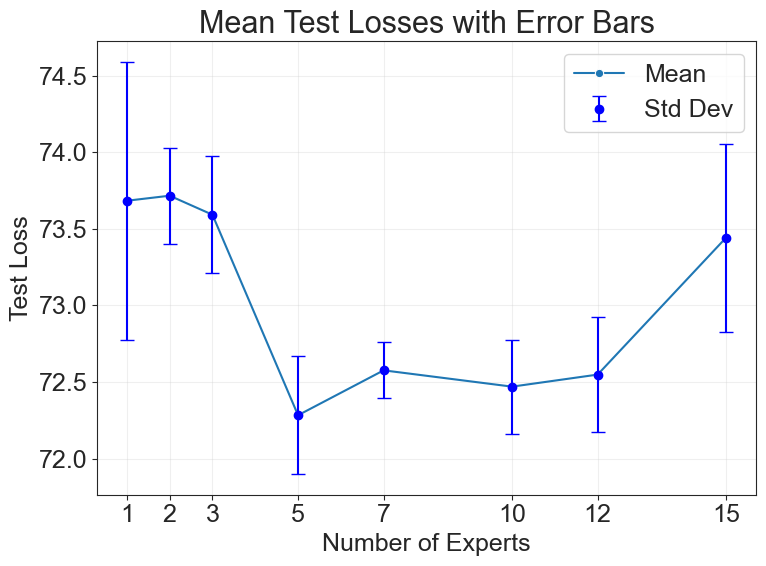

In [41]:
# Extract mean and standard deviation from losses_experts_stats
means = [losses_experts_stats[k]['mean'] for k in n_experts]
stds = [losses_experts_stats[k]['std'] for k in n_experts]

plt.figure(figsize=(8, 6))
sns.lineplot(x=n_experts, y=means, marker='o', label='Mean', err_style="bars", ci=None)
plt.errorbar(n_experts, means, yerr=stds, fmt='o', capsize=5, color='blue', label='Std Dev')


plt.title('Mean Test Losses with Error Bars')
plt.xlabel('Number of Experts')
plt.ylabel('Test Loss')
plt.xticks(n_experts)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### MNIST Fashion

In [42]:
with open('results/losses_experts_digits.pkl', 'rb') as f:
    losses_experts = pickle.load(f)

n_experts = list(losses_experts.keys())

In [43]:
# Calculate the mean and standard deviation of those entries
losses_experts_stats = {k: {'mean': np.mean(v), 'std': np.std(v)} for k, v in losses_experts.items()}

C:\Users\DELL\AppData\Local\Temp\ipykernel_4944\3291052575.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=n_experts, y=fashion_means, marker='o', label='Mean', err_style="bars", ci=None)


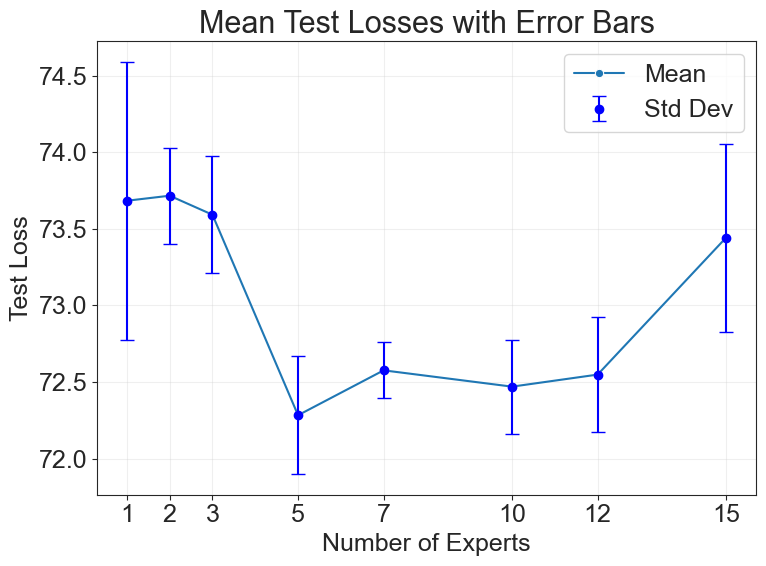

In [44]:
# Extract mean and standard deviation from losses_experts_stats
fashion_means = [losses_experts_stats[k]['mean'] for k in n_experts]
fashion_stds = [losses_experts_stats[k]['std'] for k in n_experts]

plt.figure(figsize=(8, 6))
sns.lineplot(x=n_experts, y=fashion_means, marker='o', label='Mean', err_style="bars", ci=None)
plt.errorbar(n_experts, fashion_means, yerr=fashion_stds, fmt='o', capsize=5, color='blue', label='Std Dev')

plt.title('Mean Test Losses with Error Bars')
plt.xlabel('Number of Experts')
plt.ylabel('Test Loss')
plt.xticks(n_experts)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()